# Test frequency method on Heat equation $u_t = a \triangle u$
Compare two methods:
1. Calculate the derivative via extension and fftn, then use Linear Regression with $L_1$ norm
2. Use curve fitting via pytorch for $\hat{u}(t,\xi) = \hat{u}(0,\xi)exp(t\sum_j(a_ji^{|j|}\xi^j))$ to calculate coefficients.
3. Use PDE-FIND Algorithm

Additionally we will perform Curve Fit several times and then calculate the median and standard deviation, because the parameters are randomly initialised. This can lead to different results although the other parameters used for the calculation stay the same.
We will do this without noise and for noise equal to $10^{-5}$.

In [1]:
# Packages
import numpy as np
import torch
import math
import matplotlib.pyplot as plt
import scipy.linalg
import statsmodels.api as sm
import itertools
import pysindy as ps
import pandas as pd

from scipy.optimize import minimize
from scipy.fft import fftn, ifftn, fftfreq,fft

from ipynb.fs.full.frequency_method_functions import *

In [2]:
#L_2 norm for parameter lists
def distance_para(lista,listb):
    return np.sqrt( np.square(np.array(lista)-np.array(listb)).sum() ) 

#Revert torch parameter list back to list, so distance_para calc is possible
def revert_torchparameterlist_tolist(parameter_list):
    for i in range(len(parameter_list)):
        parameter_list[i]=parameter_list[i].detach().numpy()
    parameter_list=parameter_list
    return parameter_list

### Heat equation: $u_t = \alpha \triangle u$ 
We use the Fundamental solution: $$\Theta(t,x) =  \frac{1}{(4\pi\alpha t)^{n/2}} exp(-\frac{x\cdot x}{4\alpha t})$$ in 2 and 3 dimensional case.

## 2 dimensions

In [3]:
#Create dataframes to save data
a=2.0
#filepath where you want to save the filed
filepath=r"/home/math/hauger/Dokumente/Bachelor-Arbeit/results_data/heat_equation"
noise_df_pdefind = pd.DataFrame(index=range(0,11),columns=["parameters","standard deviation","distance","eps"])
noise_df_regr = pd.DataFrame(index=range(0,11),columns=["parameters","standard deviation","distance","eps"])
noise_df_curve = pd.DataFrame(index=range(0,11),columns=["parameters","standard deviation","distance","eps"])

real_para_pdefind = [[0,a]]
real_para_regr = [0,0,a]
real_para_curve = [0,0,a]

list_para_pdefind =[]
list_para_regr=[]
list_para_curve =[]

In [8]:
T,X,t,x= create_data_2d(0.01,2,5,150,100)
a = 2.0
u = 1.0/(np.sqrt(4*np.pi*a*T))*np.exp(-(X*X)/(4*a*T))
para_regr=frequency_method_regr(u,[x,t],order=2)
para_find=pde_find(u,t,x,order=2)
print("Real Coefficients")
print((0,0,a))
print("Regression")
print(para_regr)
print("PDE-Find")
print(para_find)

(u)' = 1.574 u_11
Real Coefficients
(0, 0, 2.0)
Regression
[-1.50340949e-03 -3.83959021e-07  1.96930565e+00]
PDE-Find
[[0.         1.57427169]]


CurveFit
99 0.04078125118866556
[Parameter containing:
tensor([-0.2449], dtype=torch.float64, requires_grad=True), Parameter containing:
tensor([-0.0009], dtype=torch.float64, requires_grad=True), Parameter containing:
tensor([1.4686], dtype=torch.float64, requires_grad=True)]
199 0.039689742653011686
[Parameter containing:
tensor([-0.2359], dtype=torch.float64, requires_grad=True), Parameter containing:
tensor([1.5719e-05], dtype=torch.float64, requires_grad=True), Parameter containing:
tensor([1.5221], dtype=torch.float64, requires_grad=True)]
299 0.03967613595650955
[Parameter containing:
tensor([-0.2358], dtype=torch.float64, requires_grad=True), Parameter containing:
tensor([1.0234e-06], dtype=torch.float64, requires_grad=True), Parameter containing:
tensor([1.5342], dtype=torch.float64, requires_grad=True)]
399 0.03967613119749781
[Parameter containing:
tensor([-0.2357], dtype=torch.float64, requires_grad=True), Parameter containing:
tensor([1.6595e-05], dtype=torch.float64, requ

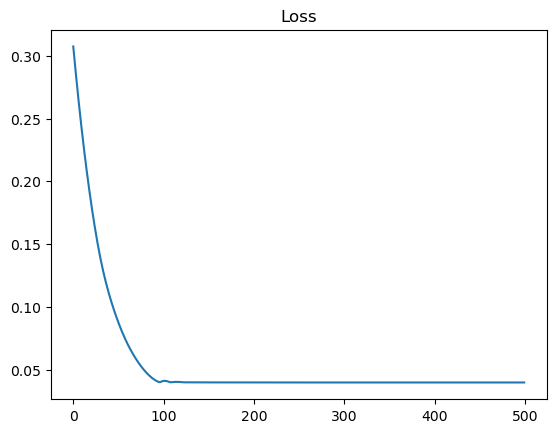

[Parameter containing:
tensor([-0.2358], dtype=torch.float64, requires_grad=True), Parameter containing:
tensor([-2.1406e-05], dtype=torch.float64, requires_grad=True), Parameter containing:
tensor([1.5343], dtype=torch.float64, requires_grad=True)]


In [9]:
print("CurveFit")
para_curve=frequency_method_curvefit(u,T,[x],ax=[0],order=2,print_loss=True,epochs=500)
print(para_curve)

In [13]:
noise_df_pdefind.loc[0,["standard deviation","eps","distance"]]=[0.0,0.0,distance_para(para_find,real_para_pdefind)]
noise_df_pdefind.at[0,"parameters"]=para_find

noise_df_regr.loc[0,["standard deviation","eps","distance"]]=[0.0,0.0,distance_para(para_regr,real_para_regr)]
noise_df_regr.at[0,"parameters"]=para_regr

para_curve=np.array(revert_torchparameterlist_tolist(para_curve)).reshape(3)
#para_curve=np.array(para_curve).reshape(3)
noise_df_curve.loc[0,["standard deviation","eps","distance"]]=[0.0,0.0,distance_para(para_curve,real_para_curve)]
noise_df_curve.at[0,"parameters"]=para_curve

list_para_pdefind.append(para_find)
list_para_regr.append(para_regr)
list_para_curve.append(para_curve)

#### Add Noise and save Results

#### 1. Calculate results for Regression and Pde Find with Noise

In [17]:
# Pde Find and Linear Regression
# 2 dim + noise 
u_rms = np.sqrt(np.mean(u*u))
eps = 1e-10
std_deviation = eps*u_rms

for i in range (10):
    noise = np.random.normal(0,std_deviation,u.shape)
    u_noise = u.copy()+noise
    #Calculate parameters
    para_pdefind = pde_find(u_noise,t,x,order=2,print_model=False)
    para_regr = frequency_method_regr(u_noise,[x,t],order=2)
    #Save std_dev, distance, eps in dataframe
    noise_df_pdefind.loc[i+1,["standard deviation","distance","eps"]] = [std_deviation,
                                                                       distance_para(para_pdefind,real_para_pdefind)
                                                                      ,eps]
    noise_df_regr.loc[i+1,["standard deviation","distance","eps"]] = [std_deviation,
                                                                       distance_para(para_regr,real_para_regr)
                                                                      ,eps]
    #Save parameters
    list_para_pdefind.append(para_pdefind)
    list_para_regr.append(para_regr)
    noise_df_pdefind.at[i+1,"parameters"]=para_pdefind
    noise_df_regr.at[i+1,"parameters"]=para_regr
    
    #Update noise
    eps *=10
    std_deviation *=10

#### 2. Calculate results for Curve Fit with Noise

In [18]:
# Curve Fit
# 2 dim + noise 
u_rms = np.sqrt(np.mean(u*u))
eps = 1e-10
std_deviation = eps*u_rms

for i in range (10):
    noise = np.random.normal(0,std_deviation,u.shape)
    u_noise = u.copy()+noise
    #Calculate parameters
    para_curve=frequency_method_curvefit(u_noise,T,[x],ax=[0],order=2,print_loss=False,epochs=500)
    para_curve=np.array(revert_torchparameterlist_tolist(para_curve)).reshape(3)
    #Save std_dev, distance, eps in dataframe
    noise_df_curve.loc[i+1,["standard deviation","distance","eps"]] = [std_deviation,
                                                                       distance_para(para_curve,real_para_curve)
                                                                      ,eps]
    #Save parameters
    list_para_curve.append(para_curve)
    noise_df_curve.at[i+1,"parameters"]=para_curve
    
    #Update noise
    eps *=10
    std_deviation *=10

#### Plot Noise

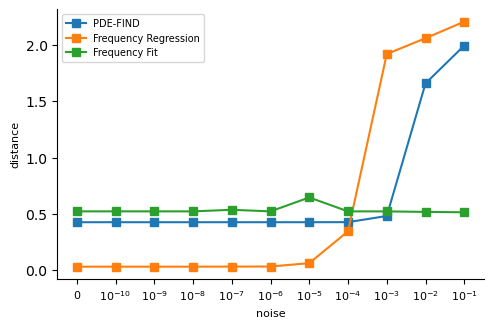

In [19]:
plt.figure(figsize=(5.5,3.5))
mysize=8
xticks=["$\mathregular{0}$"]
for i in range(10):
    xticks.append("$\mathregular{10^{"+str(-10+i)+"}}$")

ax=plt.subplot(111)
default_x_ticks = range(len(xticks))
ax.plot(default_x_ticks,noise_df_pdefind["distance"],'s-',color='tab:blue',label = 'PDE-FIND')
ax.plot(default_x_ticks,noise_df_regr["distance"],'s-',color='tab:orange',label='Frequency Regression')
ax.plot(default_x_ticks,noise_df_curve["distance"],'s-',color='tab:green',label='Frequency Fit')
ax.ticklabel_format(style='sci',scilimits=(-3,4),axis='both')
plt.xlabel("noise",size=mysize)
plt.ylabel("distance",size=mysize)
plt.xticks(default_x_ticks, xticks,size=mysize)
plt.legend(loc=2,prop={'size': 7})
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
plt.show()

#### Print Parameters with Noise: 

PDE-Find

In [20]:
for i in range(len(list_para_pdefind)):
    print("Noise "+str(i)+": "+str(list_para_pdefind[i])) 

Noise 0: [[0.         1.57427169]]
Noise 1: [[-3.69720781e-11  1.57427169e+00]]
Noise 2: [[-1.76603931e-09  1.57427169e+00]]
Noise 3: [[9.18661393e-09 1.57427169e+00]]
Noise 4: [[-8.35332196e-08  1.57427164e+00]]
Noise 5: [[-1.49389326e-06  1.57427153e+00]]
Noise 6: [[-2.20944017e-06  1.57426803e+00]]
Noise 7: [[-2.28339719e-04  1.57371407e+00]]
Noise 8: [[-2.74568560e-05  1.51907738e+00]]
Noise 9: [[0.00247607 0.34105234]]
Noise 10: [[-0.02600441  0.0048463 ]]


Linear Regression

In [21]:
for i in range(len(list_para_regr)):
    print("Noise "+str(i)+": "+str(list_para_regr[i])) 

Noise 0: [-1.50340949e-03 -3.83959021e-07  1.96930565e+00]
Noise 1: [-1.50225136e-03 -1.19086777e-06  1.96930502e+00]
Noise 2: [-1.50064242e-03  6.19149268e-06  1.96930992e+00]
Noise 3: [-1.53503214e-03  1.43927332e-05  1.96929276e+00]
Noise 4: [-1.54781215e-03  8.42569889e-05  1.96885095e+00]
Noise 5: [-1.80882947e-03 -6.50837368e-06  1.96795627e+00]
Noise 6: [-4.17794165e-03  1.23570148e-05  1.93814124e+00]
Noise 7: [-0.03467965  0.0063178   1.65683584]
Noise 8: [-0.30959534 -0.00482684  0.10538719]
Noise 9: [-0.50538346 -0.02098156  0.00261096]
Noise 10: [-9.28857953e-01 -7.82865537e-02 -5.76411012e-04]


Curve Fit

In [22]:
for i in range(len(list_para_curve)):
    print("Noise "+str(i)+": "+str(list_para_curve[i].reshape(3))) 

Noise 0: [-2.35753832e-01 -2.14061079e-05  1.53426542e+00]
Noise 1: [-2.35743154e-01  1.02127764e-08  1.53419306e+00]
Noise 2: [-2.35768886e-01 -4.05516345e-05  1.53419055e+00]
Noise 3: [-2.35764022e-01 -4.09168063e-04  1.53428373e+00]
Noise 4: [-2.35783007e-01 -2.18265994e-08  1.51867778e+00]
Noise 5: [-2.35830822e-01  2.53194122e-07  1.53426919e+00]
Noise 6: [-2.36221747e-01  1.65169947e-05  1.39920254e+00]
Noise 7: [-2.35758722e-01  5.81237847e-06  1.53427620e+00]
Noise 8: [-2.35802441e-01 -3.33005635e-04  1.53454705e+00]
Noise 9: [-0.23553003  0.00253995  1.53947411]
Noise 10: [-0.23327012 -0.0207558   1.5425143 ]


In [23]:
#Save data in csv frame
noise_df_pdefind.to_csv(filepath+"/noise_pdefind_2d.csv",sep=';')
noise_df_regr.to_csv(filepath+"/noise_regression_2d.csv",sep=';')
noise_df_curve.to_csv(filepath+"/noise_curve_2d.csv",sep=';')

### Curve Fit: Perform several times
Because Curve Fit depending on the random initialising of parameters, will calculate differernt results.
We perform Curve Fitting 20 times and then calculate the mean and standard deviation of the computed parameters.
We will perform this without noise and with noise $10^{-5}$

In [24]:
T,X,t,x= create_data_2d(0.01,2,5,150,100)
a = 2.0
u = 1.0/(np.sqrt(4*np.pi*a*T))*np.exp(-(X*X)/(4*a*T))

iter_num =20
number_para = 3
#Create dataframe for saving data
df_curve_iter = pd.DataFrame(index=range(iter_num),columns=["parameters","parameters with noise"])
df_curve_iter_stdmean=pd.DataFrame(index=range(number_para),columns = ["mean","std","mean noise","std noise"])

In [25]:
#without noise
para_curve_fit_median = []
for i in range(iter_num):
    para_curve = frequency_method_curvefit(u,T,[x],ax=[0],order=2,print_loss=False,epochs=500)
    para_curve=np.array(revert_torchparameterlist_tolist(para_curve)).reshape(number_para)
    df_curve_iter.at[i,"parameters"]=para_curve
    para_curve_fit_median.append(para_curve) 

In [26]:
#with noise
para_curve_fit_median_noise = []
u_rms = np.sqrt(np.mean(u*u))
eps = 1e-5
std_deviation = eps*u_rms
noise = np.random.normal(0,std_deviation,u.shape)
u_noise = u.copy()+noise
for i in range(iter_num):
    para_curve = frequency_method_curvefit(u_noise,T,[x],ax=[0],order=2,print_loss=False,epochs=500)
    para_curve=np.array(revert_torchparameterlist_tolist(para_curve)).reshape(number_para)
    df_curve_iter.at[i,"parameters with noise"]=para_curve
    para_curve_fit_median_noise.append(para_curve) 

#### Plot Results

In [36]:
mean = np.zeros(number_para)
std = np.zeros(number_para)
mean_noise = mean.copy()
std_noise = std.copy()
boxplot_data=[]
boxplot_data_noise=[]
for i in range(len(mean)):
    #no noise
    para = [v[i] for v in para_curve_fit_median]
    mean[i] = np.mean(para)
    std[i] = np.std(para)
    boxplot_data.append(np.array(para))
    #with noiese
    para_noise = [v[i] for v in para_curve_fit_median_noise]
    mean_noise[i] = np.mean(para_noise)
    std_noise[i] = np.std(para_noise)
    boxplot_data_noise.append(np.array(para))

In [28]:
#Save mean and standard deviation in dataframe
df_curve_iter_stdmean["mean"]=mean
df_curve_iter_stdmean["std"]=std
df_curve_iter_stdmean["mean noise"]=mean_noise
df_curve_iter_stdmean["std noise"]=std_noise

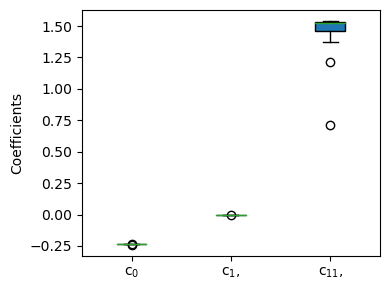

In [41]:
#with noise
fig, ax = plt.subplots(figsize=(4,3))
x=np.arange(1,number_para+1)
c="tab:green"
ax.boxplot(boxplot_data, patch_artist=True,medianprops=dict(color=c))
ax.set_ylabel('Coefficients')
ax.set_xticks(x)
ax.set_xticklabels(["$\mathregular{c_0}$","$\mathregular{c_1}$,","$\mathregular{c_{11}}$,"])
plt.tight_layout()
plt.show()

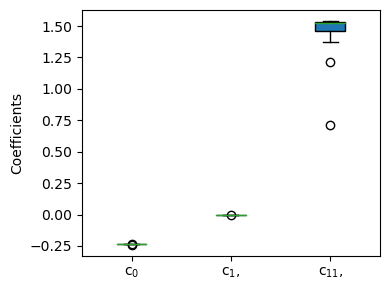

In [40]:
#with noise
fig, ax = plt.subplots(figsize=(4,3))
x=np.arange(1,number_para+1)
c="tab:green"
ax.boxplot(boxplot_data_noise, patch_artist=True,medianprops=dict(color=c))
ax.set_ylabel('Coefficients')
ax.set_xticks(x)
ax.set_xticklabels(["$\mathregular{c_0}$","$\mathregular{c_1}$,","$\mathregular{c_{11}}$,"])
plt.tight_layout()
plt.show()

In [31]:
#Save data locally in csv file
df_curve_iter.to_csv(filepath+"/curve_iter_2d.csv",sep=';')
df_curve_iter_stdmean.to_csv(filepath+"/curve_iter_meanstd_2d.csv",sep=';')

## 3 dimensions

In [3]:
a=2
#filepath where you want to save the filed
filepath=r"/home/math/hauger/Dokumente/Bachelor-Arbeit/results_data/heat_equation"
noise_df_pdefind = pd.DataFrame(index=range(0,11),columns=["parameters","standard deviation","distance","eps"])
noise_df_regr = pd.DataFrame(index=range(0,11),columns=["parameters","standard deviation","distance","eps"])
noise_df_curve = pd.DataFrame(index=range(0,11),columns=["parameters","standard deviation","distance","eps"])

real_para_curve = [0,0,0,a,0,a]
real_para_pdefind = [[0,a,0,0,a]]
real_para_regr = [0,0,0,a,0,a]

list_para_pdefind =[]
list_para_regr=[]
list_para_curve =[]

In [4]:
T,X,Y,t,x,y = create_data_3d(T_start=0.01, T_end=5, L_x=5,L_y=5, N_t=200, N_x=150,N_y=150)
u = 1.0/(4*np.pi*a*T) * np.exp(-(X*X+Y*Y)/(4*a*T) )

 #### 1. Linear Regression

In [5]:
#Regression 3 dim
print("Real Coefficients")
print("u,u_x,u_y,u_xx,u_xy,u_yy")
print((0,0,0,a,0,a))
print("Regression")
para_regr=frequency_method_regr(u,[x,t,y],order=2)
print(para_regr)

Real Coefficients
u,u_x,u_y,u_xx,u_xy,u_yy
(0, 0, 0, 2, 0, 2)
Regression
[-6.88498613e-02 -1.91648009e-07 -1.35880132e-08  1.54041156e+00
 -7.14954707e-09  1.54041159e+00]


In [6]:
noise_df_regr.loc[0,["standard deviation","eps","distance"]]=[0.0,0.0,distance_para(para_regr,real_para_regr)]
noise_df_regr.at[0,"parameters"]=para_regr

#### Add Noise and save Results: Linear Regression

In [7]:
#Linear Regression 3 dim + noise 
# computational a lot of work!!
u_rms = np.sqrt(np.mean(u*u))
eps = 1e-10
std_deviation = eps*u_rms

for i in range (10):
    print(i)
    noise = np.random.normal(0,std_deviation,u.shape)
    u_noise = u.copy()+noise
    #Calculate parameters
    para_regr = frequency_method_regr(u_noise,[x,t,y],order=2)
    #Save std_dev, distance, eps in dataframe
    noise_df_regr.loc[i+1,["standard deviation","distance","eps"]] = [std_deviation,
                                                                       distance_para(para_regr,real_para_regr)
                                                                      ,eps]
    list_para_regr.append(para_regr)
    noise_df_regr.at[i+1,"parameters"]=para_regr
    
    #Update noise
    eps *=10
    std_deviation *=10

0
1
2
3
4
5
6
7
8
9


 #### 2. PDE Find

In [8]:
#PDE Find
a=2
t = np.linspace(0.01, 5, num=200)
x = np.linspace(-5.0/2.0, 5.0/2.0, num=150)
y = np.linspace(-5.0/2.0, 5.0/2.0, num=150)
Y,X,T = np.meshgrid(y,x,t)
dt = t[1]-t[0]

u = 1.0/(4*np.pi*a*T) * np.exp(-(X*X+Y*Y)/(4*a*T) )
u_sindy = u.reshape(len(x),len(y),len(t),1)

Xm, Ym = np.meshgrid(x, y)
spatial_grid = np.asarray([Xm, Ym]).T

pde_lib = ps.PDELibrary(
    derivative_order=2,
    spatial_grid=spatial_grid
)

 # u in shape (len(x),len(t),len(y))
optimizer = ps.STLSQ(threshold=0.0)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer,feature_names=["u"])
model.fit(u_sindy,t=dt)
model.print()
para_find= model.coefficients()
print(para_find)

(u)' = 0.969 u_22 + 0.969 u_11
[[0.        0.9691577 0.        0.        0.9691577]]


In [9]:
noise_df_pdefind.loc[0,["standard deviation","eps","distance"]]=[0.0,0.0,distance_para(para_find,real_para_pdefind)]
noise_df_pdefind.at[0,"parameters"]=para_find

 #### Add noise and save results: PDE-FIND

In [10]:
#PDE Find 3 dim + noise 
u_rms = np.sqrt(np.mean(u*u))
eps = 1e-10
std_deviation = eps*u_rms

for i in range (10):
    print(i)
    noise = np.random.normal(0,std_deviation,u.shape)
    u_noise = u.copy()+noise
    #Calculate parameters
    model.fit(u_noise.reshape(len(x),len(y),len(t),1),t=dt)
    para_pdefind = model.coefficients()
    #Save std_dev, distance, eps in dataframe
    noise_df_pdefind.loc[i+1,["standard deviation","distance","eps"]] = [std_deviation,
                                                                       distance_para(para_pdefind,real_para_pdefind)
                                                                      ,eps]
    list_para_pdefind.append(para_pdefind)
    noise_df_pdefind.loc[i+1,"parameters"]=np.array(para_pdefind)
    
    #Update noise
    eps *=10
    std_deviation *=10

0
1
2
3
4
5
6
7
8
9


#### 3. Curve Fit

In [4]:
#Curve Fit 3 dim
#Use less data points otherwise inf values encountered
a=2
T,X,Y,t,x,y = create_data_3d(T_start=0.01, T_end=5, L_x=5,L_y=5, N_t=200, N_x=150,N_y=150)
u = 1.0/(4*np.pi*a*T) * np.exp(-(X*X+Y*Y)/(4*a*T) )

CurveFit


/home/math/hauger/anaconda3/envs/ba/lib/python3.9/site-packages/torch/autograd/__init__.py:154: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  /opt/conda/conda-bld/pytorch_1648016052946/work/aten/src/ATen/native/Copy.cpp:244.)
  Variable._execution_engine.run_backward(


99 0.02507100214273856
[Parameter containing:
tensor([-0.4567], dtype=torch.float64, requires_grad=True), Parameter containing:
tensor([0.0028, 0.0034], dtype=torch.float64, requires_grad=True), Parameter containing:
tensor([0.8832, 0.1582, 1.3704], dtype=torch.float64, requires_grad=True)]
199 0.020514603602455075
[Parameter containing:
tensor([-0.4322], dtype=torch.float64, requires_grad=True), Parameter containing:
tensor([-2.0573e-05, -1.0384e-04], dtype=torch.float64, requires_grad=True), Parameter containing:
tensor([1.1437, 0.0825, 1.5820], dtype=torch.float64, requires_grad=True)]
299 0.01917448774752791
[Parameter containing:
tensor([-0.4246], dtype=torch.float64, requires_grad=True), Parameter containing:
tensor([-3.5326e-07, -5.1130e-06], dtype=torch.float64, requires_grad=True), Parameter containing:
tensor([1.3277, 0.0386, 1.6134], dtype=torch.float64, requires_grad=True)]
399 0.01878934804309406
[Parameter containing:
tensor([-0.4227], dtype=torch.float64, requires_grad=T

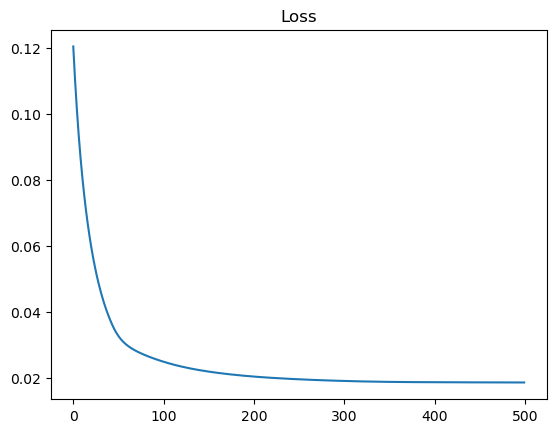

[Parameter containing:
tensor([-0.4215], dtype=torch.float64, requires_grad=True), Parameter containing:
tensor([3.6320e-07, 8.8518e-07], dtype=torch.float64, requires_grad=True), Parameter containing:
tensor([1.4897, 0.0072, 1.5853], dtype=torch.float64, requires_grad=True)]


In [5]:
#dauert 25 min
print("CurveFit")
para_curve=frequency_method_curvefit(u,T,[x,y],ax=[0,2],order=2,print_loss=True,epochs=500)
print(para_curve)

In [6]:
para_curve = np.concatenate( revert_torchparameterlist_tolist(para_curve), axis=0 )
noise_df_curve.loc[0,["standard deviation","eps","distance"]]=[0.0,0.0,distance_para(para_curve,real_para_curve)]
noise_df_curve.at[0,"parameters"]=para_curve

#### Add noise and save results: Curve Fit

In [7]:
# Curve Fit: will take a long time!!
# computational a lot of work!!
# 3 dim + noise 
u_rms = np.sqrt(np.mean(u*u))
eps = 1e-10
std_deviation = eps*u_rms

for i in range (10):
    print(i)
    noise = np.random.normal(0,std_deviation,u.shape)
    u_noise = u.copy()+noise
    #Calculate parameters
    para_curve=frequency_method_curvefit(u_noise,T,[x,y],ax=[0,2],order=2,epochs=500)
    # If infinity values encounterd in curvefit para_curve = None
    # Then skip saving and calculating distance
    if para_curve != None:
        para_curve = np.concatenate( revert_torchparameterlist_tolist(para_curve), axis=0 )
        #Save std_dev, distance, eps in dataframe
        noise_df_curve.loc[i+1,["standard deviation","distance","eps"]] = [std_deviation,
                                                                           distance_para(para_curve,real_para_curve)
                                                                          ,eps]
        #Save parameters
    list_para_curve.append(para_curve)
    noise_df_curve.at[i+1,"parameters"]=para_curve
    
    #Update noise
    eps *=10
    std_deviation *=10

0
1
2
Error: inf values in y_pred caused by torch.exp
Epoch: 0
3
4
5
6
7
8
9
Error: inf values in y_pred caused by torch.exp
Epoch: 0


#### Plot Noise

In [19]:
#To read calculated data
#noise_df_pdefind = pd.read_csv(filepath+"/noise_pdefind_3d.csv",sep=';')
#noise_df_regr = pd.read_csv(filepath+"/noise_regression_3d.csv",sep=';')
np.array(default_x_ticks)[mask_curve]

array([0, 1, 2, 4, 5, 6, 7, 8, 9])

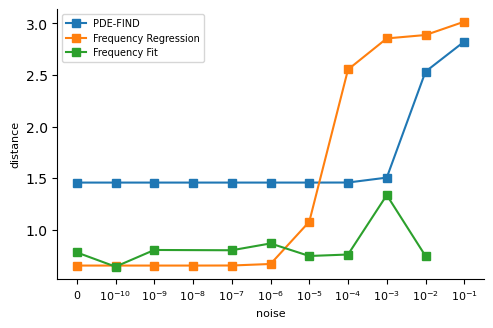

In [20]:
mask_curve = np.isfinite(noise_df_curve["distance"].astype(np.double) )

plt.figure(figsize=(5.5,3.5))
mysize=8
xticks=["$\mathregular{0}$"]
for i in range(10):
    xticks.append("$\mathregular{10^{"+str(-10+i)+"}}$")

ax=plt.subplot(111)
default_x_ticks = range(len(xticks))
ax.plot(default_x_ticks,noise_df_pdefind["distance"],'s-',color='tab:blue',label = 'PDE-FIND')
ax.plot(default_x_ticks,noise_df_regr["distance"],'s-',color='tab:orange',label='Frequency Regression')
ax.plot(np.array(default_x_ticks)[mask_curve],noise_df_curve["distance"][mask_curve],'s-',color='tab:green',label='Frequency Fit')
ax.ticklabel_format(style='sci',scilimits=(-3,4),axis='both')
plt.xlabel("noise",size=mysize)
plt.ylabel("distance",size=mysize)
plt.xticks(default_x_ticks, xticks,size=mysize)
plt.legend(loc=2,prop={'size': 7})
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
plt.show()

#### Print Parameters with Noise: 

PDE-FIND

In [25]:
for i in range(len(noise_df_pdefind["parameters"] )):
    print("Noise "+str(i)+": "+str(noise_df_pdefind["parameters"][i])) 

Noise 0: [[0.        0.9691577 0.        0.        0.9691577]]
Noise 1: [[ 8.45657358e-13  9.69157697e-01  4.36570205e-13 -1.67969714e-12
   9.69157697e-01]]
Noise 2: [[ 1.60809836e-11  9.69157697e-01 -4.45631150e-11  6.88458550e-12
   9.69157697e-01]]
Noise 3: [[-8.83701052e-11  9.69157697e-01 -1.19996037e-10  1.35694156e-10
   9.69157697e-01]]
Noise 4: [[-4.61793532e-09  9.69157697e-01  2.52036710e-09 -1.25059417e-09
   9.69157696e-01]]
Noise 5: [[2.06754031e-08 9.69157657e-01 2.89787734e-09 1.27848125e-09
  9.69157657e-01]]
Noise 6: [[4.02997444e-07 9.69154149e-01 1.77953568e-07 6.56430434e-08
  9.69154143e-01]]
Noise 7: [[-3.15886234e-06  9.68804529e-01  2.41977031e-06 -4.55147798e-07
   9.68805025e-01]]
Noise 8: [[-4.87612181e-05  9.35101160e-01  1.44219969e-05 -1.27938190e-05
   9.35180100e-01]]
Noise 9: [[ 3.84533144e-04  2.08822390e-01 -2.02731438e-04 -7.35704821e-05
   2.08921295e-01]]
Noise 10: [[ 5.19378988e-04  2.66717198e-03  1.38890584e-03 -1.85405025e-05
   2.64990194e-0

Linear Regression

In [26]:
for i in range(len(noise_df_regr["parameters"] )):
    print("Noise "+str(i)+": "+str(noise_df_regr["parameters"][i])) 

Noise 0: [-6.88498613e-02 -1.91648009e-07 -1.35880132e-08  1.54041156e+00
 -7.14954707e-09  1.54041159e+00]
Noise 1: [-6.88497497e-02  5.75174544e-08  2.11082201e-07  1.54041155e+00
  4.64849965e-09  1.54041155e+00]
Noise 2: [-6.88503238e-02 -1.09677808e-06 -3.82157896e-07  1.54041133e+00
  6.04368245e-07  1.54041131e+00]
Noise 3: [-6.88547748e-02  4.93615239e-06  2.94736242e-07  1.54040628e+00
 -8.47841597e-07  1.54041085e+00]
Noise 4: [-6.90265457e-02  1.70384271e-05 -1.11875009e-05  1.53998786e+00
 -2.19282722e-05  1.53999003e+00]
Noise 5: [-7.77261137e-02 -2.80517503e-05 -1.60716448e-04  1.53023914e+00
  8.44459146e-05  1.53025846e+00]
Noise 6: [-1.55318141e-01 -4.37333012e-05  8.92785733e-05  1.24526608e+00
  2.38938272e-05  1.24530366e+00]
Noise 7: [-4.00723779e-01 -1.62063170e-04  3.23941198e-04  2.16687679e-01
  4.24725474e-04  2.16495490e-01]
Noise 8: [-4.02025990e-01  4.45734012e-04  4.16171560e-04  1.31019886e-03
 -1.69730318e-05  1.34536089e-03]
Noise 9: [-5.82797331e-01  4

Curve Fit

In [9]:
for i in range(len(list_para_curve)):
    print("Noise "+str(i)+": "+str(list_para_curve[i])) 

Noise 0: [-2.52041074e-01  1.60545179e-07  3.04544195e-09  1.50747265e+00
  6.03709371e-08  1.67265558e+00]
Noise 1: [-4.23796709e-01  2.43862904e-07 -1.26663715e-06  1.49330458e+00
  1.30730444e-07  1.54053052e+00]
Noise 2: None
Noise 3: [-4.20152265e-01 -2.72094694e-10  4.88648296e-09  1.57726551e+00
  2.06141040e-01  1.50465923e+00]
Noise 4: [-4.25088061e-01 -5.29150947e-08  1.09484020e-07  1.41292366e+00
  9.80336225e-03  1.52244804e+00]
Noise 5: [-4.20401945e-01 -1.90118442e-06 -6.75892412e-08  1.56820691e+00
  2.94460632e-02  1.56067521e+00]
Noise 6: [-4.15037781e-01  1.31401363e-05  1.67500450e-05  1.57471354e+00
  1.06898215e-02  1.52523727e+00]
Noise 7: [-4.45602501e-01 -3.00350050e-05  2.71999897e-05  8.92428723e-01
  2.00052429e-01  1.43331672e+00]
Noise 8: [-4.20309544e-01  1.27642809e-04  1.65279090e-04  1.56725119e+00
  4.63750913e-04  1.56132141e+00]
Noise 9: None


In [10]:
#Save data in csv frame
noise_df_pdefind.to_csv(filepath+"/noise_pdefind_3d.csv",sep=';')
noise_df_regr.to_csv(filepath+"/noise_regression_3d.csv",sep=';')
noise_df_curve.to_csv(filepath+"/noise_curve_3d.csv",sep=';')

### Curve Fit: Perform several times
Because Curve Fit depending on the random initialising of parameters, will calculate differernt results.
We perform Curve Fitting 20 times and then calculate the mean and standard deviation of the computed parameters.
We will perform this without noise and with noise $10^{-5}$

In [27]:
#Regression 3 dim
#Use less data points otherwise inf values encountered
a=2
T,X,Y,t,x,y = create_data_3d(T_start=0.01, T_end=5, L_x=5,L_y=5, N_t=200, N_x=150,N_y=150)
u = 1.0/(4*np.pi*a*T) * np.exp(-(X*X+Y*Y)/(4*a*T) )

number_para = 6
iter_num =20
#Create dataframe for saving data
df_curve_iter = pd.DataFrame(index=range(iter_num),columns=["parameters","parameters with noise"])
df_curve_iter_stdmean=pd.DataFrame(index=range(number_para),columns = ["mean","std","mean noise","std noise"])

def convert_list_toarray(size,liste):
    array = np.zeros(size)
    j=0
    for el in liste:
        for i in range(len(el)):
            array[i+j]=el[i]
        j+=1
    return array

In [29]:
#without noise
para_curve_fit_median = []
for i in range(iter_num):
    print("Run "+str(i))
    para_curve = frequency_method_curvefit(u,T,[x,y],ax=[0,2],order=2,epochs=500)
    if para_curve!=None:
        para_curve=revert_torchparameterlist_tolist(para_curve)
        para_curve=convert_list_toarray(6,para_curve)
    df_curve_iter.at[i,"parameters"]=para_curve
    para_curve_fit_median.append(para_curve) 

Run 0
Run 1
Run 2
Run 3
Error: inf values in y_pred caused by torch.exp
Epoch: 0
Run 4
Run 5
Run 6
Run 7
Error: inf values in y_pred caused by torch.exp
Epoch: 0
Run 8
Run 9
Run 10
Error: inf values in y_pred caused by torch.exp
Epoch: 0
Run 11
Error: inf values in y_pred caused by torch.exp
Epoch: 0
Run 12
Run 13
Run 14
Run 15
Run 16
Run 17
Run 18
Run 19


In [35]:
#with noise
para_curve_fit_median_noise = []
u_rms = np.sqrt(np.mean(u*u))
eps = 1e-5
std_deviation = eps*u_rms
noise = np.random.normal(0,std_deviation,u.shape)
u_noise = u.copy()+noise
for i in range(iter_num):
    print("Run "+str(i))
    para_curve = frequency_method_curvefit(u_noise,T,[x],ax=[0],order=2,print_loss=False,epochs=500)
    if para_curve!=None:
        para_curve=revert_torchparameterlist_tolist(para_curve)
        para_curve=convert_list_toarray(6,para_curve)
    df_curve_iter.at[i,"parameters with noise"]=para_curve
    para_curve_fit_median_noise.append(para_curve) 

Run 0
Run 1
Run 2
Run 3
Run 4
Run 5
Run 6
Run 7
Run 8
Run 9
Run 10
Run 11
Run 12
Run 13
Run 14
Run 15
Run 16
Run 17
Run 18
Run 19


#### Plot Results

In [38]:
mean = np.zeros(number_para)
std = np.zeros(number_para)
mean_noise = mean.copy()
std_noise = std.copy()

for i in range(len(mean)):
    #no noise
    para=[]
    para_noise=[]
    for v in para_curve_fit_median:
        if v is not None:
            para.append(v[i])
    para=np.array(para)
    mean[i] = np.mean(para)
    std[i] = np.std(para)
    #with noise
    for v in para_curve_fit_median_noise:
        if v is not None:
            para_noise.append(v[i])
    para_noise=np.array(para_noise)
    mean_noise[i] = np.mean(para_noise)
    std_noise[i] = np.std(para_noise)

In [39]:
#Save mean and standard deviation in dataframe
df_curve_iter_stdmean["mean"]=mean
df_curve_iter_stdmean["std"]=std
df_curve_iter_stdmean["mean noise"]=mean_noise
df_curve_iter_stdmean["std noise"]=std_noise

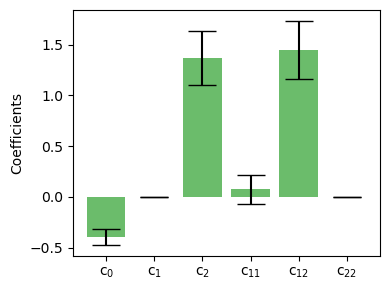

In [40]:
fig, ax = plt.subplots(figsize=(4,3))
x=np.arange(number_para)
ax.bar(x, mean, yerr=std, align='center',color='tab:green', alpha=0.7, ecolor='black', capsize=10)
ax.set_ylabel('Coefficients')
ax.set_xticks(x)
ax.set_xticklabels(["$\mathregular{c_0}$",
                    "$\mathregular{c_1}$","$\mathregular{c_2}$",
                    "$\mathregular{c_{11}}$","$\mathregular{c_{12}}$","$\mathregular{c_{22}}$"])
plt.tight_layout()
plt.show()

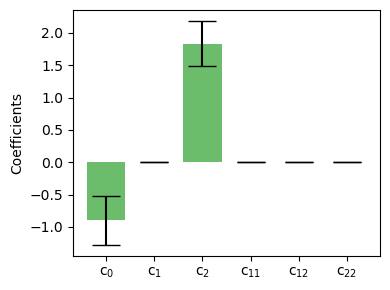

In [41]:
fig, ax = plt.subplots(figsize=(4,3))
x=np.arange(number_para)
ax.bar(x, mean_noise, yerr=std_noise, align='center',color='tab:green', alpha=0.7, ecolor='black', capsize=10)
ax.set_ylabel('Coefficients')
ax.set_xticks(x)
ax.set_xticklabels(["$\mathregular{c_0}$",
                    "$\mathregular{c_1}$","$\mathregular{c_2}$",
                    "$\mathregular{c_{11}}$","$\mathregular{c_{12}}$","$\mathregular{c_{22}}$"])
plt.tight_layout()
plt.show()

#### Print Parameters without Noise: 

In [42]:
para_curve_fit_median

[array([-4.20177537e-01, -3.43915856e-10,  1.55102773e+00, -3.37308184e-04,
         1.57544654e+00,  0.00000000e+00]),
 array([-4.20415996e-01,  1.37316993e-08,  1.55909585e+00, -3.36817741e-05,
         1.56815950e+00,  0.00000000e+00]),
 array([-3.04634604e-01,  3.03061293e-04,  1.47551847e+00,  8.44894943e-09,
         1.66304542e+00,  0.00000000e+00]),
 None,
 array([-3.93388854e-01, -1.78603273e-06,  1.09730746e+00,  3.89524868e-03,
         1.65724208e+00,  0.00000000e+00]),
 array([-3.89529754e-01,  4.32035958e-08,  1.61440580e+00,  2.87298040e-05,
         1.51270479e+00,  0.00000000e+00]),
 array([-4.23490379e-01, -7.13161924e-09,  1.59643518e+00, -3.96519054e-05,
         1.42338153e+00,  0.00000000e+00]),
 None,
 array([-4.64578831e-01, -1.94437611e-09,  1.27277386e+00,  5.29034611e-01,
         6.78640227e-01,  0.00000000e+00]),
 array([-4.50473823e-01, -2.46420685e-04,  1.41058958e+00,  1.27001843e-01,
         8.17782556e-01,  0.00000000e+00]),
 None,
 None,
 array([-4.2

#### Print Parameters with Noise: 

In [43]:
para_curve_fit_median_noise

[array([-1.23478760e+00, -7.60495339e-05,  2.43490926e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00]),
 array([-4.81516575e-01, -8.95216339e-05,  1.76645780e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00]),
 array([-8.70207463e-01, -8.66305239e-05,  1.55411064e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00]),
 array([-1.24516564e+00,  6.65643589e-05,  2.07952668e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00]),
 array([-1.18609327e+00,  2.99017535e-05,  2.09980322e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00]),
 array([-1.11461507e+00, -7.52308158e-05,  1.43833101e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00]),
 array([-1.08238236e+00,  5.61650549e-05,  2.08769227e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00]),
 array([-5.47134053e-01, -3.69775856e-05,  1.50747765e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00]),
 array([-6.22931396e-01, -6.07211318e-05

In [44]:
#Save data in csv frame
df_curve_iter.to_csv(filepath+"/curve_iter_3d.csv",sep=';')
df_curve_iter_stdmean.to_csv(filepath+"/curve_iter_meanstd_3d.csv",sep=';')

In [46]:
df_curve_iter

,parameters,parameters with noise
0,"[-0.42017753709943234, -3.4391585580741744e-10...","[-1.234787599568063, -7.604953385875691e-05, 2..."
1,"[-0.42041599589247924, 1.3731699272430598e-08,...","[-0.48151657512035584, -8.952163394977208e-05,..."
2,"[-0.3046346036145397, 0.0003030612929329555, 1...","[-0.8702074628308638, -8.663052391618417e-05, ..."
3,None,"[-1.24516564001907, 6.656435894919229e-05, 2.0..."
4,"[-0.39338885425911546, -1.7860327303190463e-06...","[-1.186093268483717, 2.9901753476636156e-05, 2..."
5,"[-0.38952975391301614, 4.320359578967399e-08, ...","[-1.1146150692203418, -7.523081583770216e-05, ..."
6,"[-0.4234903791962409, -7.131619242533672e-09, ...","[-1.082382358424989, 5.616505488008069e-05, 2...."
7,None,"[-0.5471340526885204, -3.697758561387021e-05, ..."
8,"[-0.4645788312263283, -1.944376108754783e-09, ...","[-0.6229313957078879, -6.072113177879569e-05, ..."
9,"[-0.45047382320600393, -0.0002464206852704729,...","[-1.5422389469245423, -1.857617382146727e-05, ..."


In [47]:
df_curve_iter_stdmean

,mean,std,mean noise,std noise
0,-0.393916,0.078224,-0.899685,0.375129
1,0.000003,0.000098,-0.000041,0.000074
2,1.365549,0.267622,1.834684,0.346256
3,0.074336,0.144545,0.000000,0.000000
4,1.446699,0.284082,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000
